# Store Sales

- Predict *sales* for the thousands of product families sold at Favorita stores located in Ecuador
- forecast store sales on data from Corporación Favorita, a large Ecuadorian-based grocery retailer.

### File & Data Description

File Description
- train.csv : time series of features store_nbr, family, onpromotion, and target sales.
- test.csv : having the same features as the training data without target sales.
  - The dates in the test data are for the 15 days after the last date in the training data.
- stores.csv : Store metadata, including city, state, type, and cluster.
- oil.csv : Daily oil price during both the train and test data timeframes.
  - Ecuador is an oil-dependent country and it's economical health is highly vulnerable to shocks in oil prices.
- holidays_events.csv : Holidays and Events, with metadata
  - transferred : A holiday that is transferred to another date by the government. A transferred day is more like a normal day than a holiday.
  - type : Transfer = actually celebrated day, Additional = added a regular calendar holiday, Bridge = substitute holidays, Work Day = not normally scheduled for work, holiday & event
- transactions


Data Description
- store_nbr : the store at which the products are sold.
- family : the type of product sold.
- sales : the total sales for a product family at a particular store at a given date. Fractional values are possible since products can be sold in fractional units.
- onpromotion : the total number of items in a product family that were being promoted at a store at a given date.

Note
- wages are paid on the 15th and last day of the month
- A magnitude 7.8 earthquake struck Ecuador on April 16, 2016 -> donating first need products for several weeks after the earthquake.

Data Note
| df | Variable  | description | Key | Type | processing|
| -------- |-------- |--------   |-------- |-------- |-------- |
| holidays_events | date || 2012.03.02 ~ 2017.12.26 (350일)   | datetime |  |
|  | type | holiday type |  'Holiday', 'Transfer', 'Additional', 'Bridge', 'Work Day', 'Event' | category | - event vs holiday, transfer 처리|
|  | locale | scope of holiday | 'Local', 'Regional', 'National' | category| - holiday의 적용 범위에 따른 holiday 열 추가 (locale_name & description과 함께)|
|  | locale_name   | location where holiday is hosted | city&state (23개) + Ecuador | category | 
|  | description   | name of holiday (Traslado is attached on desc front, if its transferred) | 103개 | object |
|  | transferred   | whether holiday is transferred or not | true (its actual holiday transferred), false | bool |-transfer 처리시 사용|
| oil | date | | 2013.01.01 ~ 2017.08.31 (1218일) | datetime | | 
|  | dcoilwtico | oil prices | 26.19 ~ 110.62 | float | - 결측치 43개 | 
| stores | store_nbr |  |01 ~ 54|int || 
|  | city |  | 22개 |object| | 
|  | state  ||16개 | object| |
|  | type | |'D', 'B', 'C', 'E', 'A'| category | - type vs cluster| 
|  | cluster |grouping of similar stores| 1 ~ 17|int| | 
|transactions| date | |2013.01.01 ~ 2017.08.15 | datetime | |
|| store_nbr || 01 ~ 54 | int | |
|| transactions | 하루 거래량 | 5 ~ 8359 |int64|  |
|train / test|date ||2013.01.01 ~ 2017.08.15 |datetime | | 
|| store_nbr| |01 ~ 54 |int | 
|| family| 판매된 물품의 품목| 33개 | object| - 가격대가 높은 물품일수록 sales가 더 높을 것| 
|| sales| total sales for a product family || float|  | 
|| onpromotion| total number of items in a product family that were being promoted at a store at a given date | 0 ~ 741|int | - onpormotion 개수에 따른 sales 변화|


## 라이브러리

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings(action='ignore')

sns.set(style="whitegrid") # 스타일 지정

## 데이터 모판 만들기

In [5]:
DATA_DIR = "store-sales-time-series-forecasting/"

holidays_events = pd.read_csv(DATA_DIR + "holidays_events.csv")
oil = pd.read_csv(DATA_DIR + "oil.csv")
stores = pd.read_csv(DATA_DIR + "stores.csv")
transactions = pd.read_csv(DATA_DIR + "transactions.csv")
train = pd.read_csv(DATA_DIR + "train.csv", index_col = 0)
test = pd.read_csv(DATA_DIR + "test.csv", index_col = 0)

df = pd.concat([train, test], axis=0).reset_index(drop=True)

# Data Types
holidays_events['date'] = pd.to_datetime(holidays_events['date'])
oil['date'] = pd.to_datetime(oil['date'], format = "%Y-%m-%d")
transactions['date'] = pd.to_datetime(transactions['date'], format = "%Y-%m-%d")
df['date'] = pd.to_datetime(df['date'], format = "%Y-%m-%d")
train.onpromotion = train.onpromotion.astype("float")
train.sales = train.sales.astype("float")
stores.cluster = stores.cluster.astype("int")

# train + test
number_of_train_dataset = df.sales.notnull().sum()
number_of_test_dataset = df.sales.isnull().sum()
y_true = df.pop('sales')[:number_of_train_dataset]

df

,date,store_nbr,family,onpromotion
0,2013-01-01,1,AUTOMOTIVE,0
1,2013-01-01,1,BABY CARE,0
2,2013-01-01,1,BEAUTY,0
3,2013-01-01,1,BEVERAGES,0
4,2013-01-01,1,BOOKS,0
...,...,...,...,...
3029395,2017-08-31,9,POULTRY,1
3029396,2017-08-31,9,PREPARED FOODS,0
3029397,2017-08-31,9,PRODUCE,1
3029398,2017-08-31,9,SCHOOL AND OFFICE SUPPLIES,9


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3029400 entries, 0 to 3029399
Data columns (total 4 columns):
 #   Column       Dtype         
---  ------       -----         
 0   date         datetime64[ns]
 1   store_nbr    int64         
 2   family       object        
 3   onpromotion  int64         
dtypes: datetime64[ns](1), int64(2), object(1)
memory usage: 92.5+ MB


## Missing Value

<BarContainer object of 20 artists>

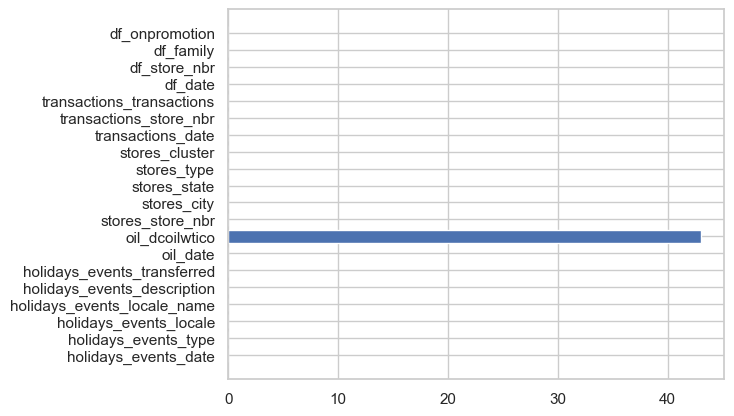

In [7]:
df_list = [holidays_events, oil, stores, transactions, df]
df_name_list = ["holidays_events", "oil", "stores", "transactions", "df"]
col_names = []

missing_value_series = pd.Series(dtype=float)

for ind, dataframe in enumerate(df_list):
  missing_value_series = pd.concat([missing_value_series, dataframe.isnull().sum()], ignore_index = True)
  col_names += list(df_name_list[ind] + "_" + dataframe.isnull().sum().index)
missing_value_series.index = col_names

plt.barh(missing_value_series.index, missing_value_series.values)

oil의 dcoilwtico가 결측치가 존재함 확인!

시계열 데이터이므로, 정규분포나 평균, 최빈값 등..보다는 전체적인 추세에 따라서 주변과 비슷한 값으로 값 채우는 것이 좋을 것이라 판단

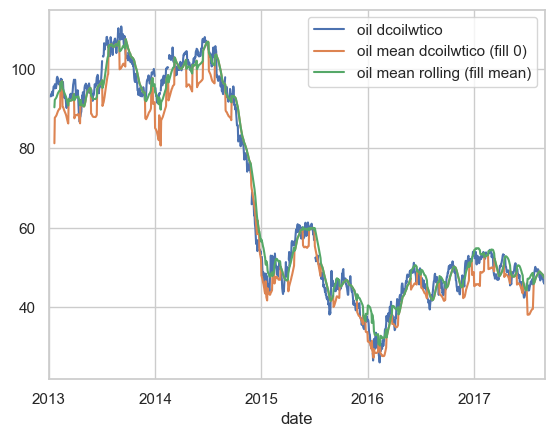

In [8]:
ax = oil.set_index('date').plot()
oil.set_index('date').fillna(0).rolling(window=15).mean().plot(ax=ax) # window 15로의 평균값 -> 기존 결측치는 0으로 채운 상태
oil.set_index('date').fillna(oil.dcoilwtico.mean()).rolling(window=15).mean().plot(ax=ax) # window 15로의 평균값 -> 기존 결측치는 평균으로 채운 상태
ax.legend(["oil dcoilwtico", "oil mean dcoilwtico (fill 0)", "oil mean rolling (fill mean)"])
# 전체 평균으로 결측치를 채운 상태로, 윈도우 15를 기준으로 평균을 냈을 때 기존 그래프와 비슷한 추세를 가짐을 확인

In [9]:
# fill NaN
oil_mean_rolling = oil.set_index('date').fillna(oil.dcoilwtico.mean()).rolling(window=15).mean()
oil_shift = oil.set_index('date').shift(-1) 
  
# 15개를 기준으로 한 평균값으로 결측치 채우기
temp_df = pd.merge(oil, oil_mean_rolling.reset_index(drop=False), how="left", on="date")
temp_df["temp_col"] = temp_df["dcoilwtico_x"].fillna(temp_df["dcoilwtico_y"])
oil = temp_df[["date", "temp_col"]]

# 하나 앞으로 값 이동한 데이터로 아직 채워지지 않은 데이터 채움
temp_df = pd.merge(oil, oil_shift.reset_index(drop=False), how="left", on="date")
temp_df["temp_col"] = temp_df["temp_col"].fillna(temp_df["dcoilwtico"])
oil = temp_df[["date", "temp_col"]].rename(columns={'temp_col':'dcoilwtico'})

oil

,date,dcoilwtico
0,2013-01-01,93.14
1,2013-01-02,93.14
2,2013-01-03,92.97
3,2013-01-04,93.12
4,2013-01-07,93.20
...,...,...
1213,2017-08-25,47.65
1214,2017-08-28,46.40
1215,2017-08-29,46.46
1216,2017-08-30,45.96


## Feature Engineering

### Holidays events
- type : event vs holidays, transferred
- locale에 따라 holiday 유무 판단

In [10]:
# transferred : true일 경우, normal day, type : Transfer = actually celebrated day
holidays = holidays_events.copy()

normal_days = holidays.loc[holidays['transferred'] == True].drop("transferred", axis = 1)
actual_days = holidays.loc[holidays['type'] == "Transfer"].drop("transferred", axis = 1)
actual_days.type = normal_days.type.values # 실제 기념한 휴일을 holiday type으로 변경
# actual_days.description = normal_days.description.values # desc 처리

holidays.drop("transferred", axis = 1, inplace = True)

holidays.iloc[actual_days.index] = actual_days
holidays.drop(index = normal_days.index, inplace = True)
holidays.reset_index(drop=True)

,date,type,locale,locale_name,description
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba
...,...,...,...,...,...
333,2017-12-22,Additional,National,Ecuador,Navidad-3
334,2017-12-23,Additional,National,Ecuador,Navidad-2
335,2017-12-24,Additional,National,Ecuador,Navidad-1
336,2017-12-25,Holiday,National,Ecuador,Navidad


12개의 이전된 날을 삭제 후, 실제 기념된 날을 휴일 처리

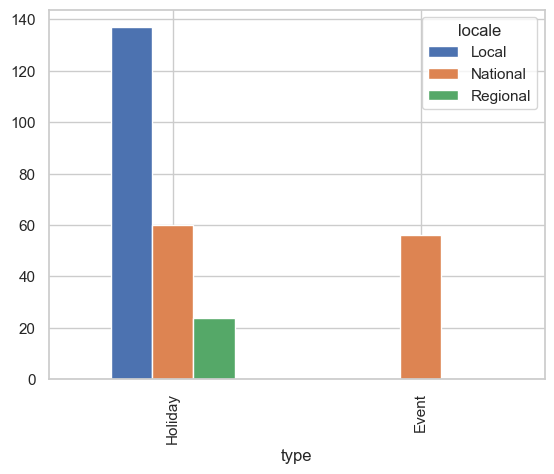

In [11]:
# events vs holiday
temp = holidays.groupby(["type", "locale"]).count().loc[["Holiday", "Event"]]["locale_name"]
ax = temp.unstack().plot(kind="bar")

holiday인 경우, 지역별 휴일도 섞여있지만, event의 경우 항상 전국적으로 이루어진 휴일!
- 따로, 삭제하거나 합치는 것이 아닌 event type은 그대로 유지

In [12]:
# locale에 따라 store의 위치와 비교하여 holiday 여부 판단
holidays_event = holidays.copy()
holidays_event.columns = ["date", "holiday_type", "scope_of_holiday", "where_holiday_hosted", "holidays_name"]
holidays_scope = holidays_event[["date", "scope_of_holiday", "where_holiday_hosted"]]

df_store = pd.merge(df, stores[["store_nbr", "city", "state"]], on = "store_nbr", how = 'left')
df_store["is_holiday"] = False

date = holidays_scope.loc[holidays_scope['scope_of_holiday'] == 'National', "date"].index
df_store.loc[date, "is_holiday"] = True
df_store

def is_holiday(x, scope):  
  holidays_temp = x[x['scope_of_holiday'] == scope][['date', 'where_holiday_hosted']]
  if scope == "Regional": check_col = "state"
  else: check_col = "city"
  df_temp = pd.merge(left = df_store, right = holidays_temp, left_on = ['date', check_col] , right_on = ['date', 'where_holiday_hosted'], how = 'left')
  df_temp.loc[df_temp["where_holiday_hosted"].notnull(), "is_holiday"] = True
  return df_temp.drop(["where_holiday_hosted"], axis=1)

df_store = is_holiday(holidays_scope, "Regional")
df_store = is_holiday(holidays_scope, "Local").drop_duplicates()

df_store

,date,store_nbr,family,onpromotion,city,state,is_holiday
0,2013-01-01,1,AUTOMOTIVE,0,Quito,Pichincha,False
1,2013-01-01,1,BABY CARE,0,Quito,Pichincha,False
2,2013-01-01,1,BEAUTY,0,Quito,Pichincha,False
3,2013-01-01,1,BEVERAGES,0,Quito,Pichincha,False
4,2013-01-01,1,BOOKS,0,Quito,Pichincha,False
...,...,...,...,...,...,...,...
3029659,2017-08-31,9,POULTRY,1,Quito,Pichincha,False
3029660,2017-08-31,9,PREPARED FOODS,0,Quito,Pichincha,False
3029661,2017-08-31,9,PRODUCE,1,Quito,Pichincha,False
3029662,2017-08-31,9,SCHOOL AND OFFICE SUPPLIES,9,Quito,Pichincha,False


In [13]:
# holiday type 열 붙이기
df_store_is_holiday = df_store.loc[df_store["is_holiday"] == True].reset_index()
df_store_is_holiday = pd.merge(df_store_is_holiday, holidays_event, on = "date", how = 'left')

temp = pd.merge(df_store, df_store_is_holiday, left_index=True, right_on="index", how="left").reset_index()
df_store["holiday_type"] = temp["holiday_type"]

all_df = df_store[["date", "store_nbr", "family", "onpromotion", "holiday_type", "is_holiday"]].fillna("normal_day")
all_df

,date,store_nbr,family,onpromotion,holiday_type,is_holiday
0,2013-01-01,1,AUTOMOTIVE,0,normal_day,False
1,2013-01-01,1,BABY CARE,0,normal_day,False
2,2013-01-01,1,BEAUTY,0,normal_day,False
3,2013-01-01,1,BEVERAGES,0,normal_day,False
4,2013-01-01,1,BOOKS,0,normal_day,False
...,...,...,...,...,...,...
3029659,2017-08-31,9,POULTRY,1,normal_day,False
3029660,2017-08-31,9,PREPARED FOODS,0,normal_day,False
3029661,2017-08-31,9,PRODUCE,1,normal_day,False
3029662,2017-08-31,9,SCHOOL AND OFFICE SUPPLIES,9,normal_day,False


### Stores
- type vs cluster

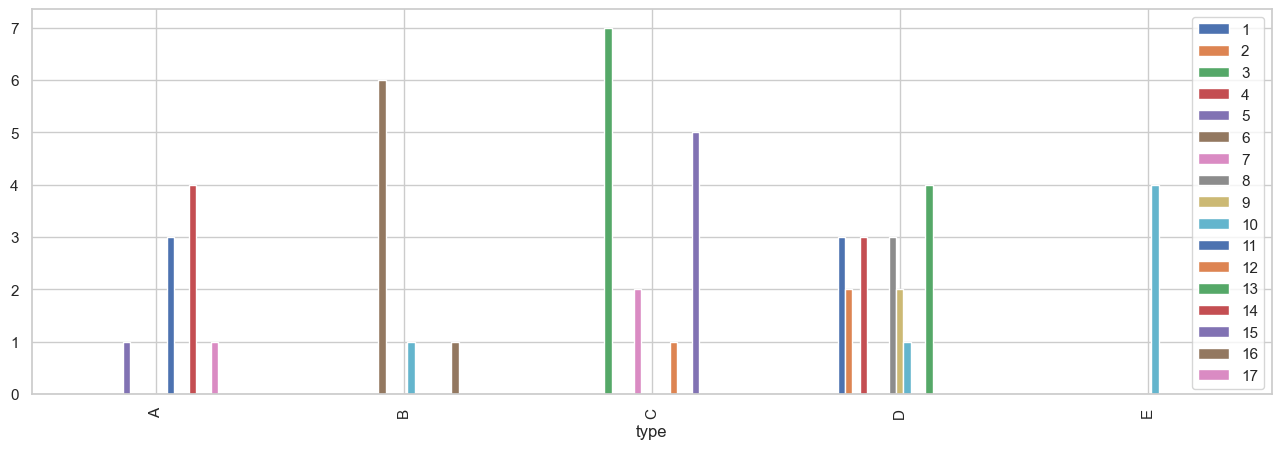

In [14]:
compare_type_with_cluster = stores.groupby(["type", "cluster"]).count()["store_nbr"]
compare_type_with_cluster = pd.DataFrame(stores.groupby(["type", "cluster"]).count()["store_nbr"])
ax = compare_type_with_cluster.unstack().plot(kind="bar", figsize = (16, 5), width=0.5)
ax.legend(np.sort(stores.cluster.unique()))

cluster가 type의 소분류인줄 알았으나, 아닌 것 같음
-> family와의 관계를 살펴봤으면 좋았을 것 같음
- 다른 분류 기준이라 판단하고, 모판에 추가

In [15]:
stores_type = stores.copy()
all_df = pd.merge(all_df, stores_type[["store_nbr", "type", "cluster"]], on = "store_nbr", how="left")

all_df

,date,store_nbr,family,onpromotion,holiday_type,is_holiday,type,cluster
0,2013-01-01,1,AUTOMOTIVE,0,normal_day,False,D,13
1,2013-01-01,1,BABY CARE,0,normal_day,False,D,13
2,2013-01-01,1,BEAUTY,0,normal_day,False,D,13
3,2013-01-01,1,BEVERAGES,0,normal_day,False,D,13
4,2013-01-01,1,BOOKS,0,normal_day,False,D,13
...,...,...,...,...,...,...,...,...
3029395,2017-08-31,9,POULTRY,1,normal_day,False,B,6
3029396,2017-08-31,9,PREPARED FOODS,0,normal_day,False,B,6
3029397,2017-08-31,9,PRODUCE,1,normal_day,False,B,6
3029398,2017-08-31,9,SCHOOL AND OFFICE SUPPLIES,9,normal_day,False,B,6


### 월급날, 지진 열 추가
- wages are paid on the 15th and last day of the month
-  A magnitude 7.8 earthquake struck Ecuador on April 16, 2016 -> donating first need products for several weeks after the earthquake.

In [16]:
all_df["wages_day"] = False
all_df[all_df["date"].dt.day == 15]["wages_day"] = True
all_df[all_df.date.isin(pd.date_range("2012-03-02", "2017-12-26", freq="M"))]["wages_day"] = True
all_df

,date,store_nbr,family,onpromotion,holiday_type,is_holiday,type,cluster,wages_day
0,2013-01-01,1,AUTOMOTIVE,0,normal_day,False,D,13,False
1,2013-01-01,1,BABY CARE,0,normal_day,False,D,13,False
2,2013-01-01,1,BEAUTY,0,normal_day,False,D,13,False
3,2013-01-01,1,BEVERAGES,0,normal_day,False,D,13,False
4,2013-01-01,1,BOOKS,0,normal_day,False,D,13,False
...,...,...,...,...,...,...,...,...,...
3029395,2017-08-31,9,POULTRY,1,normal_day,False,B,6,False
3029396,2017-08-31,9,PREPARED FOODS,0,normal_day,False,B,6,False
3029397,2017-08-31,9,PRODUCE,1,normal_day,False,B,6,False
3029398,2017-08-31,9,SCHOOL AND OFFICE SUPPLIES,9,normal_day,False,B,6,False


In [17]:
all_df["earthquake"] = False
all_df[all_df["date"] == "2016-04-16"].earthquake = True
all_df

,date,store_nbr,family,onpromotion,holiday_type,is_holiday,type,cluster,wages_day,earthquake
0,2013-01-01,1,AUTOMOTIVE,0,normal_day,False,D,13,False,False
1,2013-01-01,1,BABY CARE,0,normal_day,False,D,13,False,False
2,2013-01-01,1,BEAUTY,0,normal_day,False,D,13,False,False
3,2013-01-01,1,BEVERAGES,0,normal_day,False,D,13,False,False
4,2013-01-01,1,BOOKS,0,normal_day,False,D,13,False,False
...,...,...,...,...,...,...,...,...,...,...
3029395,2017-08-31,9,POULTRY,1,normal_day,False,B,6,False,False
3029396,2017-08-31,9,PREPARED FOODS,0,normal_day,False,B,6,False,False
3029397,2017-08-31,9,PRODUCE,1,normal_day,False,B,6,False,False
3029398,2017-08-31,9,SCHOOL AND OFFICE SUPPLIES,9,normal_day,False,B,6,False,False


### transactions

<AxesSubplot: xlabel='date', ylabel='transactions'>

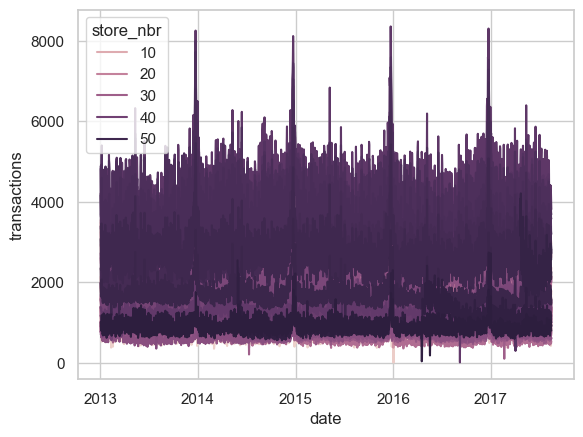

In [18]:
sns.lineplot(x='date', y='transactions', hue='store_nbr', data = transactions.sort_values(["store_nbr", "date"]))

매년 말마다 store_nbr와 관계 없이 상승하는 것을 볼 수 있음

<AxesSubplot: xlabel='year', ylabel='transactions'>

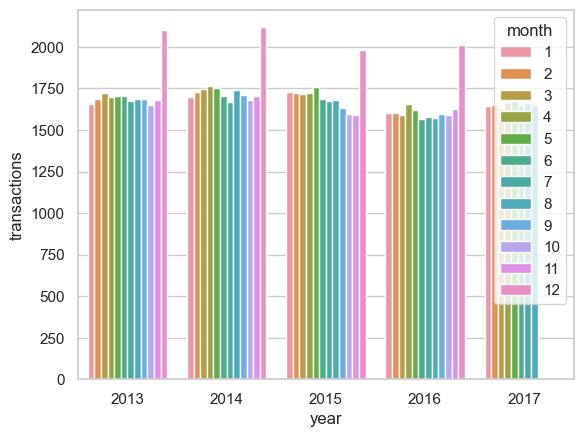

In [19]:
trans = transactions.copy()
trans["year"] = trans.date.dt.year
trans["month"] = trans.date.dt.month
sns.barplot(x="year", y="transactions", hue = "month", data = trans, ci=False)

sales에도 영향을 줄 것이므로, 모판에 추가!

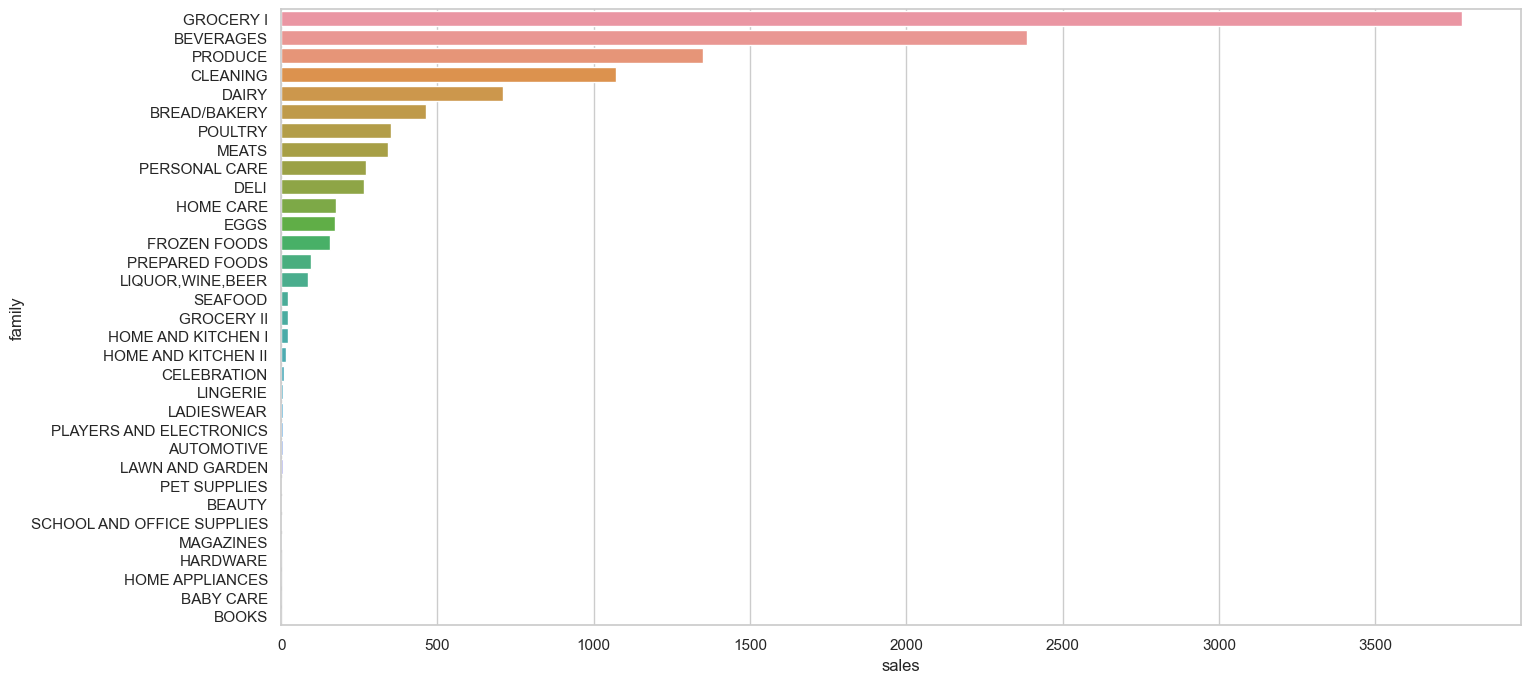

In [20]:
train_family = train.copy()
family_sales = train_family.groupby('family')['sales'].mean().sort_values(ascending=False)

plt.figure(figsize=(16,8))
sns.barplot(x=family_sales.values, y=family_sales.index, orient = "h")
plt.xlabel("sales")
plt.show()

family에 따른 sales가 확연하게 차이나는 것을 확인 -> 해당 비율 반영

In [21]:
family_sales_ratio = family_sales.div(family_sales.sum())

trans = transactions.copy()
temp = all_df[["date", "store_nbr", "family"]]

trans_family = pd.merge(temp, trans, on=["date", "store_nbr"], how="left").fillna(0)

def te(x):
  family = x.family
  transact = x.transactions
  return transact * family_sales_ratio.loc[family]

from tqdm import tqdm
tqdm.pandas()

all_df["transactions"] = trans_family.progress_apply(te, axis=1)

100%|██████████| 3029400/3029400 [00:56<00:00, 53746.19it/s]


### oil

<AxesSubplot: xlabel='dcoilwtico', ylabel='sales'>

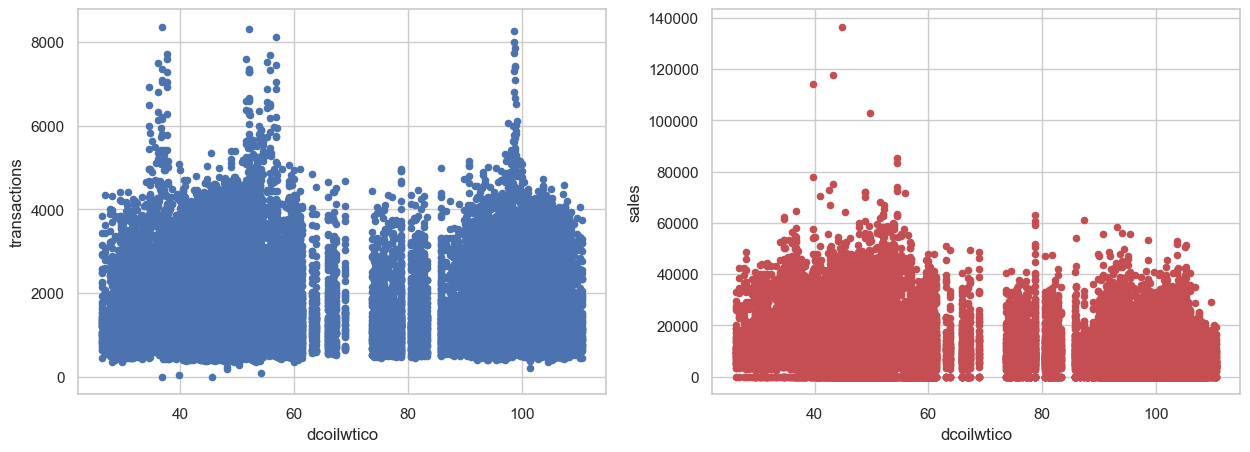

In [22]:
oil_ = oil.copy()

train['date'] = pd.to_datetime(train['date'], format = "%Y-%m-%d")
oil_['date'] = pd.to_datetime(oil_['date'], format = "%Y-%m-%d")

temp = pd.merge(train.groupby(["date", "store_nbr"]).sales.sum().reset_index(), transactions, how = "left")
temp = pd.merge(temp, oil_, how = "left")

fig, axes = plt.subplots(1, 2, figsize = (15,5))
temp.plot.scatter(x = "dcoilwtico", y = "transactions", ax=axes[0])
temp.plot.scatter(x = "dcoilwtico", y = "sales", ax=axes[1], color = "r")

oil 의존국이어서 oil price에 따른 transaction과 sales와의 변화를 살펴보았지만, 별다른 추새가 보이지 않는다

## Category columns

In [23]:
all_df

,date,store_nbr,family,onpromotion,holiday_type,is_holiday,type,cluster,wages_day,earthquake,transactions
0,2013-01-01,1,AUTOMOTIVE,0,normal_day,False,D,13,False,False,0.0
1,2013-01-01,1,BABY CARE,0,normal_day,False,D,13,False,False,0.0
2,2013-01-01,1,BEAUTY,0,normal_day,False,D,13,False,False,0.0
3,2013-01-01,1,BEVERAGES,0,normal_day,False,D,13,False,False,0.0
4,2013-01-01,1,BOOKS,0,normal_day,False,D,13,False,False,0.0
...,...,...,...,...,...,...,...,...,...,...,...
3029395,2017-08-31,9,POULTRY,1,normal_day,False,B,6,False,False,0.0
3029396,2017-08-31,9,PREPARED FOODS,0,normal_day,False,B,6,False,False,0.0
3029397,2017-08-31,9,PRODUCE,1,normal_day,False,B,6,False,False,0.0
3029398,2017-08-31,9,SCHOOL AND OFFICE SUPPLIES,9,normal_day,False,B,6,False,False,0.0


In [24]:
def merge_and_get(ldf, rdf, on, how="inner", index=None):
  if index is True:
    return pd.merge(ldf, rdf, how=how, left_index=True, right_index=True)
  else:
    return pd.merge(ldf, rdf, how=how, on=on)

In [25]:
# 원핫인코딩
one_hot_encoding = pd.get_dummies(all_df)
one_hot_encoding

,date,store_nbr,onpromotion,is_holiday,cluster,wages_day,earthquake,transactions,family_AUTOMOTIVE,family_BABY CARE,...,holiday_type_Additional,holiday_type_Event,holiday_type_Holiday,holiday_type_Work Day,holiday_type_normal_day,type_A,type_B,type_C,type_D,type_E
0,2013-01-01,1,0,False,13,False,False,0.0,1,0,...,0,0,0,0,1,0,0,0,1,0
1,2013-01-01,1,0,False,13,False,False,0.0,0,1,...,0,0,0,0,1,0,0,0,1,0
2,2013-01-01,1,0,False,13,False,False,0.0,0,0,...,0,0,0,0,1,0,0,0,1,0
3,2013-01-01,1,0,False,13,False,False,0.0,0,0,...,0,0,0,0,1,0,0,0,1,0
4,2013-01-01,1,0,False,13,False,False,0.0,0,0,...,0,0,0,0,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3029395,2017-08-31,9,1,False,6,False,False,0.0,0,0,...,0,0,0,0,1,0,1,0,0,0
3029396,2017-08-31,9,0,False,6,False,False,0.0,0,0,...,0,0,0,0,1,0,1,0,0,0
3029397,2017-08-31,9,1,False,6,False,False,0.0,0,0,...,0,0,0,0,1,0,1,0,0,0
3029398,2017-08-31,9,9,False,6,False,False,0.0,0,0,...,0,0,0,0,1,0,1,0,0,0


In [26]:
# date 제거
all_of_df = one_hot_encoding.copy()
all_of_df["year"] = one_hot_encoding["date"].dt.year
all_of_df["month"] = one_hot_encoding["date"].dt.month
all_of_df["day"] = one_hot_encoding["date"].dt.day
all_of_df = all_of_df.drop("date", axis=1)

## 모델 구축

In [27]:
X_train = all_of_df[:number_of_train_dataset].values
X_test = all_of_df[number_of_train_dataset:].values
y_train = y_true.copy()

In [28]:
X_train

array([[1, 0, False, ..., 2013, 1, 1],
       [1, 0, False, ..., 2013, 1, 1],
       [1, 0, False, ..., 2013, 1, 1],
       ...,
       [9, 148, False, ..., 2017, 8, 15],
       [9, 8, False, ..., 2017, 8, 15],
       [9, 0, False, ..., 2017, 8, 15]], dtype=object)

In [29]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()
reg = model.fit(X_train, y_train)
y_pre = reg.predict(X_test)

In [593]:
# 제출 코드
idx = (all_of_df[number_of_train_dataset:].index).tolist()
submission_columns = ["id", "sales"]
submission_df = pd.DataFrame([idx, y_pre]).T
submission_df.columns = submission_columns

for col_name in submission_columns:
  submission_df[col_name] = submission_df[col_name].astype(int)

submission_df.to_csv(os.path.join(DATA_DIR,"linearRegression_without_selection.csv"), index=False)

## Feature Selection

### With RFE_26

In [30]:
from sklearn.feature_selection import RFE

# select = RFE(LinearRegression(n_features_to_select=5, step=1))
# n_features_to_select : 남겨질 feature의 수 지정
# step : 매 스텝마다 제거될 feature의 수
select = RFE(LinearRegression())
select.fit(X_train, y_train)

X_train_selected = select.transform(X_train) # 학습시킨 select를 x_train에 적용
X_train_selected.shape

(3000888, 26)

In [31]:
selected_col = all_of_df.columns[select.get_support()]
print('선택된 feature의 수:', selected_col)

선택된 feature의 수: Index(['family_AUTOMOTIVE', 'family_BABY CARE', 'family_BEAUTY',
       'family_BEVERAGES', 'family_BOOKS', 'family_BREAD/BAKERY',
       'family_CELEBRATION', 'family_CLEANING', 'family_DAIRY',
       'family_GROCERY I', 'family_HARDWARE', 'family_HOME APPLIANCES',
       'family_LADIESWEAR', 'family_LAWN AND GARDEN', 'family_LINGERIE',
       'family_MAGAZINES', 'family_PET SUPPLIES',
       'family_PLAYERS AND ELECTRONICS', 'family_PRODUCE',
       'family_SCHOOL AND OFFICE SUPPLIES', 'holiday_type_Additional',
       'holiday_type_Event', 'holiday_type_Holiday', 'holiday_type_Work Day',
       'holiday_type_normal_day', 'type_A'],
      dtype='object')


In [618]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()
reg = model.fit(X_train_selected, y_train)
X_test = all_of_df[selected_col][number_of_train_dataset:]
y_pre = reg.predict(X_test)

# 제출 코드
idx = (all_of_df[number_of_train_dataset:].index).tolist()
submission_columns = ["id", "sales"]
submission_df = pd.DataFrame([idx, y_pre]).T
submission_df.columns = submission_columns

for col_name in submission_columns:
  submission_df[col_name] = submission_df[col_name].astype(int)

submission_df.to_csv(os.path.join(DATA_DIR,"linearRegression_with_RFE.csv"), index=False)

### with SelectFromModel_5

In [45]:
from sklearn.feature_selection import SelectFromModel # 통계학을 사용하여 모델 없애주는 것

sfm = SelectFromModel(estimator=LinearRegression())
sfm.fit(X_train, y_train)

X_train_selected = sfm.transform(X_train)
print('선택된 feature의 수:', all_of_df.columns[sfm.get_support()])

선택된 feature의 수: Index(['type_A', 'type_B', 'type_C', 'type_D', 'type_E'], dtype='object')


### RFE_39

In [623]:
from sklearn.feature_selection import RFE

# 전체 열의 75% = 39개
select = RFE(LinearRegression(), n_features_to_select=39, step=1)
# n_features_to_select : 남겨질 feature의 수 지정
# step : 매 스텝마다 제거될 feature의 수
select.fit(X_train, y_train)

X_train_selected = select.transform(X_train) # 학습시킨 select를 x_train에 적용
selected_col_39 = all_of_df.columns[select.get_support()]
print('선택된 feature의 수:', selected_col_39)

선택된 feature의 수: Index(['onpromotion', 'is_holiday', 'family_AUTOMOTIVE', 'family_BABY CARE',
       'family_BEAUTY', 'family_BEVERAGES', 'family_BOOKS',
       'family_BREAD/BAKERY', 'family_CELEBRATION', 'family_CLEANING',
       'family_DAIRY', 'family_DELI', 'family_FROZEN FOODS',
       'family_GROCERY I', 'family_GROCERY II', 'family_HARDWARE',
       'family_HOME AND KITCHEN I', 'family_HOME AND KITCHEN II',
       'family_HOME APPLIANCES', 'family_LADIESWEAR', 'family_LAWN AND GARDEN',
       'family_LINGERIE', 'family_LIQUOR,WINE,BEER', 'family_MAGAZINES',
       'family_MEATS', 'family_PET SUPPLIES', 'family_PLAYERS AND ELECTRONICS',
       'family_PREPARED FOODS', 'family_PRODUCE',
       'family_SCHOOL AND OFFICE SUPPLIES', 'family_SEAFOOD',
       'holiday_type_Additional', 'holiday_type_Holiday',
       'holiday_type_normal_day', 'type_A', 'type_B', 'type_C', 'type_E',
       'year'],
      dtype='object')


In [627]:
X_train_selected.shape

(3000888, 39)

In [ ]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()
reg = model.fit(X_train_selected, y_train)
X_test = all_of_df[selected_col_39][number_of_train_dataset:]
y_pre = reg.predict(X_test)

In [630]:
# 제출 코드
idx = (all_of_df[number_of_train_dataset:].index).tolist()
submission_columns = ["id", "sales"]
submission_df = pd.DataFrame([idx, y_pre]).T
submission_df.columns = submission_columns

for col_name in submission_columns:
  submission_df[col_name] = submission_df[col_name].astype(int)

submission_df.to_csv(os.path.join(DATA_DIR,"linearRegression_with_RFE_39.csv"), index=False)

## Scaling

In [624]:
def feature_scaling(df, scaling_strategy = "min-max", columns = None):
  if columns == None:
    columns = [col_name for col_name in df.columns]
  for col_name in columns:
    if scaling_strategy == "min-max":
      df[col_name] = (df[col_name] - df[col_name].min()) / (df[col_name].max() - df[col_name].min())
    elif scaling_strategy == "z-score":
      df[col_name] = (df[col_name] - df[col_name].mean()) / (df[col_name].std())
  return df

<AxesSubplot: xlabel='date'>

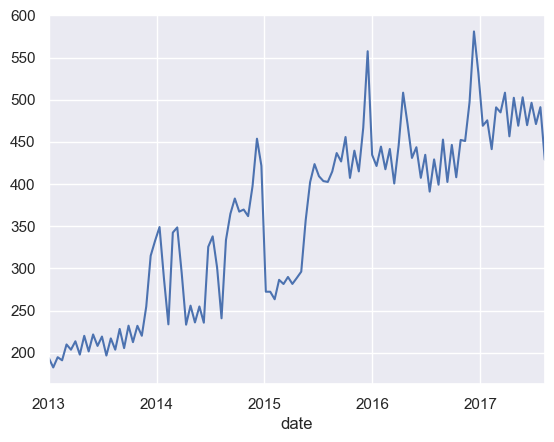

In [658]:
temp = all_df[:number_of_train_dataset].copy()
sales_all_df = pd.merge(temp, y_true, left_index=True, right_index=True)
sales_all_df.set_index("date").resample('15D').mean()["sales"].plot()

- 시간은 스케일링 보단 시간 간격의 차 등을 알아보는 게 좋을 것 같긴 하지만, 일단 scaling

In [665]:
scaled_all_of_df = feature_scaling(all_of_df, columns = ["transactions", "onpromotion", "year"])

In [667]:
from sklearn.linear_model import LinearRegression

X_train = scaled_all_of_df[:number_of_train_dataset].values
X_test = scaled_all_of_df[number_of_train_dataset:].values
y_train = y_true.copy()

model = LinearRegression()
reg = model.fit(X_train, y_train)
y_pre = reg.predict(X_test)

# 제출 코드
idx = (all_of_df[number_of_train_dataset:].index).tolist()
submission_columns = ["id", "sales"]
submission_df = pd.DataFrame([idx, y_pre]).T
submission_df.columns = submission_columns

for col_name in submission_columns:
  submission_df[col_name] = submission_df[col_name].astype(int)

submission_df.to_csv(os.path.join(DATA_DIR,"linearRegression_with_scaling.csv"), index=False)

# Kaggle

In [32]:
X_train = X_train_selected.copy()
X_test = all_of_df[selected_col][number_of_train_dataset:]

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, 
                                                    test_size=0.3)

In [41]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()
reg = model.fit(X_train_selected, y_train)
y_pre = reg.predict(X_test)

### submit

In [ ]:
# 제출 코드
idx = (all_of_df[number_of_train_dataset:].index).tolist()
submission_columns = ["id", "sales"]
submission_df = pd.DataFrame([idx, y_pre]).T
submission_df.columns = submission_columns

for col_name in submission_columns:
  submission_df[col_name] = submission_df[col_name].astype(int)

submission_df.to_csv(os.path.join(DATA_DIR,"linearRegression_with_RFE.csv"), index=False)